In [1]:
import pandas as pd

In [3]:
S = pd.read_csv('Instruments_Reviews.csv')
S.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
S_noNA = S.dropna(thresh=len(S) * 0.5, axis=1)

In [5]:
S_noNA = S_noNA.astype(str)

In [6]:
S["reviews"] = S["reviewText"] + " " + S["summary"]
S.drop(columns = ["reviewText", "summary"], axis = 1, inplace = True)

In [7]:
def Labelling(Rows):
  if(Rows["overall"] > 3.0):
    Label = "Positive"
  elif(Rows["overall"] < 3.0):
    Label = "Negative"
  else:
    Label = "Neutral"
  return Label

In [9]:
S["sentiment"] = S.apply(Labelling, axis = 1)

In [12]:
import matplotlib.pyplot as plt

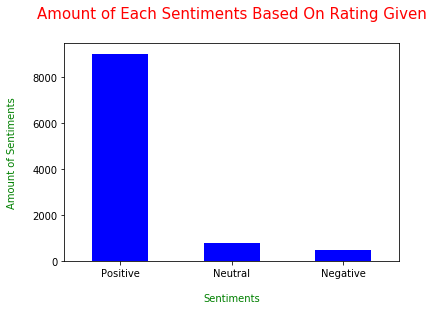

In [13]:
S["sentiment"].value_counts().plot(kind = "bar", color = "blue")
plt.title("Amount of Each Sentiments Based On Rating Given", loc = "center", fontsize = 15, color = "red", pad = 25)
plt.xlabel("Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.xticks(rotation = 0)
plt.ylabel("Amount of Sentiments", color = "green", fontsize = 10, labelpad = 15)
plt.show()

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
import string
def Text_Cleaning(Text):
  if isinstance(Text, str):
      Text = Text.lower()
        
      punc = str.maketrans(string.punctuation, ' '*len(string.punctuation))
      Text = Text.translate(punc)
        
      userPattern       = '@[^\s]+'
      sequencePattern   = r"(.)\1\1+"
      seqReplacePattern = r"\1\1"
  
      Text = re.sub(userPattern,' USER', Text)
      Text = re.sub('https?://\S+|www\.\S+', '', Text)
      Text = re.sub(r'\d+', '', Text)          
      Text = re.sub(r'\W+', ' ', Text)      
      Text = re.sub(r'\s+', ' ', Text).strip() 
      Text = re.sub(sequencePattern, seqReplacePattern, Text)
      return Text
  else :
      return ''

In [16]:
stop_words = set(stopwords.words("english")) - set(["not"])
Lemmatizer = WordNetLemmatizer()

def Text_Processing(Text):
  processed_tokens = []
  tokens = word_tokenize(Text)
  for token in tokens:
    if token not in stop_words:
      token = Lemmatizer.lemmatize(token)
      processed_tokens.append(token)
  
  return " ".join(processed_tokens)

In [17]:
S["reviews"] = S["reviews"].apply(lambda Text: Text_Cleaning(Text))
S["reviews"] = S["reviews"].apply(lambda Text: Text_Processing(Text))

In [20]:
Columns = ["reviewerID", "asin", "reviewerName", "helpful", "unixReviewTime", "reviewTime", "overall"]
S.drop(columns = Columns, axis = 1, inplace = True)

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

In [24]:
Encoder = LabelEncoder()
S["sentiment"] = Encoder.fit_transform(S["sentiment"])

In [26]:
TF_IDF = TfidfVectorizer(max_features = 5000, ngram_range = (2, 2))
X = TF_IDF.fit_transform(S["reviews"])
X.shape

(10261, 5000)

In [28]:
y = S["sentiment"]

In [29]:
Balancer = SMOTE(random_state = 42)
X_final, y_final = Balancer.fit_resample(X, y)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, random_state = 42)

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [36]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1]     
}

# 
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best score: 0.973005339991928


In [38]:
best_svm = grid_search.best_estimator_

cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.9751314  0.96966373 0.97074991 0.97633347 0.97314818]
Mean cross-validation score: 0.973005339991928


In [39]:
y_pred = best_svm.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2225
           1       1.00      0.94      0.97      2277
           2       1.00      0.99      0.99      2265

    accuracy                           0.97      6767
   macro avg       0.98      0.98      0.97      6767
weighted avg       0.98      0.97      0.97      6767

